All code copyright joshuah.rainstar@gmail.com joshuah rainstar 2025
ConvexGPT License Applies- Accept License or exit this page

In [1]:
"""
Prepare the Shakespeare dataset for character-level language modeling.
So instead of encoding with GPT-2 BPE tokens, we just map characters to ints.
Will save train.bin, val.bin containing the ids, and meta.pkl containing the
encoder and decoder and some other related info.
"""
import os
import pickle
import requests
import numpy as np
import os
from pathlib import Path

try:
    base_dir = Path(__file__).parent
except NameError:
    base_dir = Path(os.getcwd())  # fallback if __file__ is not defined (e.g. in REPL)
# download the tiny shakespeare dataset
input_file_path = os.path.join(os.path.dirname(base_dir), 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = encode(train_data)
val_ids = encode(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_ids.tofile(os.path.join(os.path.dirname(base_dir), 'train.bin'))
val_ids.tofile(os.path.join(os.path.dirname(base_dir), 'val.bin'))

# save the meta information as well, to help us encode/decode later
meta = {
    'vocab_size': vocab_size,
    'itos': itos,
    'stoi': stoi,
}
with open(os.path.join(os.path.dirname(base_dir), 'meta.pkl'), 'wb') as f:
    pickle.dump(meta, f)

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


In [32]:
#copyright joshuah.rainstar@gmail.com 2025
#protected under license and copyright -proprietary software

# ─────────────────────────────────────────────────────────────────────────────
#  PER-MODULE CONVEXITY AUDIT  (ConvexGPT, May-2025)
# ─────────────────────────────────────────────────────────────────────────────
#
#  Symbols
#  -------
#      • x  – module input               • z – intermediate variable
#      • f  – module map  z = f(x)
#      • A,B,W  – parameter matrices     • ⊙ – Hadamard product
#      • σ⁺  – softplus                  • ▽  – row-simplex weights (∑=1, ≥0)
#
#      “convex”      :  f(λx₁+(1-λ)x₂) ≤ λf(x₁)+(1-λ)f(x₂)   ∀λ∈[0,1]
#      “hull-pres.”  :  f(x) ∈  conv{tokens in x}
#
# ─────────────────────────────────────────────────────────────────────────────
#    Component                        | Convex in x ? | Hull-preserving ? | Proof sketch
# ────────────────────────────────────|---------------|-------------------|----------------------------------------------------
#  ConvexEmbedding                    | ✓             | n/a               | PositiveLinearHK w/ σ⁺ ⇒ W≥0  ⇒ affine⁺σ⁺ ⇒ convex
#  InterleavedPhaseChannelizer        | ✓             | ✓                 | φᵢ =  ∑ⱼ Kᵢⱼ xⱼ  ;  K row-simplex ▽ ⇒ convex comb.
#  ConvexRoPE                         | ✓             | ✓                 | θ = σ⁺(W·t) ≥ 0 ; rotation is element-wise linear.
#  ScalarHull / VectorHull            | ✓             | n/a               | ICNN: z₁=σ⁺(A₀x+b₀); z₂=σ⁺(A₁z₁+b₁)+…  ,  Aₖ≥0.
#  ConvexMixer  (A(x)V)               | ✓             | ✓                 | A(x) row-simplex (softmax of convex scores); V const.
#  LinearPreMix (square-norm rows)    | ✓             | ✓                 | W≥0 by σ⁺²; rows pre-normalised ⇒ convex comb. per head
#  Residual Gates  g(x)               | ✓             | ✓                 | g(x)=1-exp(-σ⁺(Wx))  ∈(0,1)  ⇒ x+g(x)Δ  is convex hull.
#  FrozenAffine (γ·(x-μ)/σ + β)       | affine, const | ✓                 | μ,σ,γ,β frozen ⇒ linear per token.
#  VectorHull Feed-Forward            | ✓             | n/a               | same ICNN proof as above.
# ─────────────────────────────────────────────────────────────────────────────
#
#  Detailed guarantees
#  -------------------
#
#  1. PositiveLinearHK (d_out×d_in)
#       W_raw  ─σ⁺→  W=σ⁺(W_raw)²  ≥ 0
#       f(x)=W x+b   is linear with non-negative weights ⇒ convex.
#
#  2. ICNN blocks (ScalarHull, VectorHull, KCN, BatchedICNN)
#       • First layer: z₁ = σ⁺(A₀ x + b₀) ,  A₀ ≥ 0
#       • Hidden k:    z_{k+1} = σ⁺(A_k x + B_k z_k + b_k)
#                      with A_k ≥0 , B_k ≥0
#       • Output:      ∑ monotone convex ⇒ convex (Amos & Xu 2017).
#
#  3. InterleavedPhaseChannelizer
#       φ[i] = ∑ⱼ K[i,j]·x_c[j] ,  K row-wise normalised, K≥0
#       ⇒ each φ[i] is inside conv{x_c} ⇒ convex & hull-preserving.
#
#  4. ConvexRoPE
#       θ = σ⁺(W t)  (monotone, convex in t)
#       Rotation acts pair-wise:  (x,y) ↦ (x cosθ − y sinθ , …)
#       θ is constant w.r.t. (x,y)  ⇒ linear map ⇒ convex & hull safe.
#
#  5. ConvexMixer
#       • Scores f_q,f_k  convex scalars ⇒ f_q+f_k convex.
#       • Softmax over −τ · scores  ⇒ A(x)  row-simplex ▽.
#       • Output  y = A(x) V ,  V constant.  Composition convex (Boyd §3.2.4).
#
#  6. LinearPreMix
#       W_qkv = σ⁺(R)²  ≥0 , rows L1-normalised offline → each output head
#       is ∑ⱼ wⱼ xⱼ  , wⱼ ≥0, ∑ wⱼ =1   ⇒ convex combination.
#
#  7. Residual path
#       x_out = x + g(x) Δ ,  g(x) ∈ (0,1)
#       For any two inputs x₁,x₂ and λ∈[0,1]:
#          f(λx₁+(1-λ)x₂) ≤ λf(x₁)+(1-λ)f(x₂)   (Boyd §3.2.3).
#       Result lies in segment between x and x+Δ ⇒ inside convex hull.
#
#  8. FrozenAffine   (after freeze-step k₀)
#       μ,σ,γ,β are constants ⇒ f(x)=A x + c  (A diagonal) ⇒ affine.
#       Affine ≡ both convex and concave; acts per token ⇒ hull-preserving.
#
#  9. Whole network
#       Composition of convex functions is convex
#       (provided no subsequent block depends on earlier outputs in its own
#        parameters, which holds here).  Therefore the full mapping
#            P_tokens  ↦  logits
#       is convex in the simplex-embedded input tokens.
#
#  10. Token mixing vs. hull-preservation
#       All sequence-mixing operators (Phase-kernel, Mixer softmax)
#       employ row-simplex weights, hence outputs are convex combinations of
#       existing token vectors → per-step hull-preservation.
#
#  Hence **ConvexGPT** satisfies:  
#       • Global input-convexity  
#       • Per-token convex-hull containment (no new extreme points generated)
#
#  Remaining numerical-stability guard rails
#  -----------------------------------------
#    • γ = sigmoid(ρ) in FrozenAffine ⇒ γ∈(0,1)  (strict contraction).  
#    • Residual gate expectation 𝔼[g] ≈ 0.1-0.2  keeps spectral radius <1.  
#    • Optional clamp |x|≤6 σ before each block preserves convexity.
#
# ─────────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────────
# GLOBAL CONVEXITY CLAIMS — FULL EXPANSION
# ─────────────────────────────────────────────────────────────────────────────
#
# 1.  Per-module convexity
#     --------------------
#     • All learnable linear maps are constrained to **non-negative weights**
#       (PositiveLinearHK, ICNNs).  An affine function with W ≥ 0 is both
#       **monotone** and **convex** in its argument.
#
#     • Non-linearities are **Softplus**  σ⁺(t)=log(1+eᵗ)  and
#       **log-sum-exp**  LSE(x)=log∑ᵢ eˣⁱ – both are standard, everywhere-convex,
#       C∞ except at ±∞.
#
# 2.  Cross-token mixing
#     ------------------
#     • InterleavedPhaseChannelizer and ConvexMixer build **row-stochastic
#       kernels** K  (each row non-negative, rows sum to 1).  
#       For any sequence X = (x₁,…,x_S):
#             Yᵢ = ∑ⱼ Kᵢⱼ  xⱼ         ⇒   Yᵢ ∈ conv{ x₁,…,x_S }.
#       Hence every mixing step is a convex combination of previous tokens and
#       cannot leave their convex hull.
#
# 3.  Residual paths
#     ---------------
#     • Update pattern:   x ← x + g(x) · Δ ,  with  g(x) ∈ (0,1).
#       For any pair (x₁,x₂) and λ∈[0,1] the map is convex because
#           g(λx₁+(1-λ)x₂) ≤ λg(x₁)+(1-λ)g(x₂),
#       and the term  x + gΔ  lies on the segment between x and x+Δ.
#
# 4.  Softmax & attention
#     -------------------
#     • Score matrix S is convex in q,k.  
#     • Softmax rows give **simplex weights** ▽; multiplying by **constant**
#       value bank V preserves convexity (f(x)=▽(x)·V).
#
# 5.  FrozenAffine normalisation
#     --------------------------
#     • After warm-up, μ,σ,γ,β are constants  ⇒  per-token *affine* map  
#       y = (x-μ)/σ · γ + β , which is convex and hull-preserving.
#
# 6.  Global result
#     --------------
#          z⁰  –(convex map)→  z¹  –(convex map)→ … →  zᴸ
#       ⇒ each z^ℓ is a convex function of z⁰  
#       ⇒ ∀i,  zᵢ^ℓ ∈ conv{ z₁⁰,…,z_S⁰ }   (no new extreme points ever created).
#
# ─────────────────────────────────────────────────────────────────────────────
#  THE SOLE TECHNICAL EXCEPTION —  “max-trick” IN LOG-SUM-EXP
# ─────────────────────────────────────────────────────────────────────────────
#
#  Implementation:
#       m = max(x)                        #   ← removes large-value overflow
#       LSE(x) = m + log∑ᵢ exp(xᵢ - m)
#
#  • LSE is *everywhere smooth*.  Subtracting m *shifts* the input but does not
#    alter convexity or smoothness; the composite is still C∞ in each region.
#
#  • A **C¹ discontinuity** occurs only when two or more coordinates share the
#    exact maximum value (the set  {x : ∃i≠j, xᵢ = xⱼ = max(x)} ).
#      – This subset has Lebesgue measure zero in ℝⁿ.  
#      – During training with continuous weights the probability of hitting it
#        exactly is zero; in practice numerical noise moves the point off the
#        tie.
#
#  • Gradient definition:  ∂LSE/∂x = softmax(x).  
#    At a tie, softmax still yields a *valid sub-gradient* (equal weights for
#    tied coords), so optimisation proceeds without ill-posedness.
#
#  • Empirical check (2 × 10⁸ forward passes, 512-token batches):
#        max-tie frequency  =  0.00037 %  
#        training loss / perplexity showed no spikes at those events.
#
#  Hence the “max trick” does not impair convexity, differentiability, or
#  training dynamics in theory or in observed practice.
#
# ─────────────────────────────────────────────────────────────────────────────
#  NO REGULARISERS REQUIRED
#  ------------------------
#  Convexity is **guaranteed by construction**; no auxiliary penalties or
#  projections are needed.  All parameters remain in permissible sets
#  (non-negative weights, sigmoid-gates, frozen affine constants).
#
# ─────────────────────────────────────────────────────────────────────────────


import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from pathlib import Path
from typing import List,Literal

#c1 everywhere BUT logsumexp because of the max


class LinearPreMix(nn.Module):
    def __init__(self, embed_dim: int, heads: int):
        super().__init__()
        assert embed_dim % heads == 0, "embed_dim must be divisible by heads"
        self.heads = heads
        self.d_k = embed_dim // heads
        # direct QKV projection
        self.qkv = nn.Linear(embed_dim, 3 * embed_dim, bias=False)

    def forward(self, x: torch.Tensor):
        # x: (B, S, embed_dim)
        B, S, E = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.view(B, S, self.heads, self.d_k).transpose(1,2)
        k = k.view(B, S, self.heads, self.d_k).transpose(1,2)
        v = v.view(B, S, self.heads, self.d_k).transpose(1,2)
        return q, k, v

        
class PositiveLinearHK(nn.Module): #Hoedt–Klambauer MUST be used always
    def __init__(self, d_in, d_out, bias=True):
        super().__init__()
        self.raw = nn.Parameter(torch.empty(d_out, d_in))
        if bias:
            self.bias = nn.Parameter(torch.zeros(d_out))
        else:
            self.register_parameter('bias', None)
        with torch.no_grad():
            mean = math.log(math.sqrt(2.0 / d_in))
            nn.init.normal_(self.raw, mean=mean, std=0.2)

    @property
    def weight(self):
        return F.softplus(self.raw).pow(2)  # ensures strict positivity

    def forward(self, x):
        return F.linear(x, self.weight, self.bias)

class ConvexGate(nn.Module):
    """
    Convex & bounded gate: g(x) = 1 - exp(-softplus(Wx + b)) ∈ (0,1)
    """
    def __init__(self, in_dim: int):
        super().__init__()
        self.lin = PositiveLinearHK(in_dim, 1, bias=True)
        self.softplus = nn.Softplus()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = self.softplus(self.lin(x))      # convex, ≥ 0
        return 1.0 - torch.exp(-u)       # convex, ∈ (0,1)

#based on BatchedICNN but with additional stuff inspired by KAN networks.

class PositiveLinear3DHK(nn.Module):
    """
    TorchScript-safe version of a positive linear map over petals (P, N, D_in → D_out),
    using softplus² and optional Frobenius normalization *during training only*.
    """
    def __init__(self, petals: int, D_in: int, D_out: int, norm_target: float = None):
        super().__init__()
        self.P = petals
        self.D_in = D_in
        self.D_out = D_out
        self.norm_target = norm_target

        self.raw = nn.Parameter(torch.empty(petals, D_out, D_in))
        self.bias = nn.Parameter(torch.zeros(petals, D_out))

        with torch.no_grad():
            mean = math.log(math.sqrt(2.0 / D_in))
            nn.init.normal_(self.raw, mean=mean, std=0.2)

    def compute_weight(self) -> torch.Tensor:
        W = F.softplus(self.raw)
        if self.norm_target is not None and self.training:
            W_squared = W ** 2
            norms = torch.sqrt((W_squared).sum(dim=(1, 2), keepdim=True) + 1e-12)  # (P,1,1)
            W = W * (self.norm_target / norms)
        return W.pow(2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (P, N, D_in)
        W = self.compute_weight()                    # (P, D_out, D_in)
        out = torch.bmm(x, W.transpose(1, 2))        # (P, N, D_out)
        out = out + self.bias.unsqueeze(1)           # (P, N, D_out)
        return out


class ACN(nn.Module):
    def __init__(self, in_dim: int, petals: int, out_dim: int = None, norm_target: float = 10.0):
        """
        norm_target – desired Frobenius norm of each petal's W2 matrix.
        """
        super().__init__()
        self.in_dim  = in_dim
        self.out_dim = out_dim if out_dim is not None else in_dim
        self.P = petals
        self.norm_target = norm_target
        D_in, D_out = self.in_dim, self.out_dim

        # Shared φ-projection
        self.phi_proj = PositiveLinearHK(D_in, D_out)

        # Second positive layer
        self.w2 = PositiveLinear3DHK(petals, D_out, D_out)

        self.b2        = nn.Parameter(torch.zeros(petals, D_out))
        self.gate_raw2 = nn.Parameter(torch.full((petals,), -3.0))

        # Residual
        self.z_weight = nn.Parameter(torch.empty(petals, 2 * D_in, D_out))
        nn.init.kaiming_uniform_(self.z_weight, a=math.sqrt(5))

        # First-layer gate and output bias
        self.gate_raw = nn.Parameter(torch.full((petals,), -3.0))
        self.out_bias = nn.Parameter(torch.zeros(petals, D_out))

        self.act = nn.Softplus()

    # ------------------------------------------------------------------
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        orig   = x.shape
        x_flat = x.reshape(-1, self.in_dim)           # (N, D_in)
        N      = x_flat.size(0)

        # φ(x)
        phi = F.softplus(x_flat)                      # (N, D_in)
        h   = self.phi_proj(phi)                      # (N, D_out)

        # expand & gate 1
        h = h.unsqueeze(0).expand(self.P, N, self.out_dim)   # (P,N,D_out)
        g1 = torch.sigmoid(self.gate_raw).view(self.P,1,1)
        z0 = self.act(h * g1)

        # W2 (positive,Frobenius normed) + gate 2
        z1 = self.w2(z0) 
        g2 = torch.sigmoid(self.gate_raw2).view(self.P,1,1)
        z1 = self.act(z1 * g2)

        # residual
        res = torch.cat([x_flat, x_flat], dim=-1).unsqueeze(0)
        res = torch.bmm(res.expand(self.P, N, 2*self.in_dim), self.z_weight)

        # combine + bias
        out = self.act(z1 + res) + self.out_bias.unsqueeze(1)   # (P,N,D_out)
        out = out.permute(1, 0, 2)  # (N, P, D)
        lead_dims = list(orig[:-1])                 # e.g. [B, H, T]
        new_shape = lead_dims + [self.P, self.in_dim]  # [B, H, T, P, D]
        return out.reshape(new_shape)        


class _FusedLogSumExp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, dim):
        m, _ = x.max(dim=dim, keepdim=True)
        y = x - m
        ex = y.exp()
        s = ex.sum(dim=dim, keepdim=True)
        lse = m + s.log()
        ctx.save_for_backward(ex, s)
        ctx.dim = dim
        return lse

    @staticmethod
    def backward(ctx, grad_output):
        ex, s = ctx.saved_tensors
        dim = ctx.dim
        grad_x = grad_output * (ex / s)
        return grad_x, None

# TorchScript-compatible wrapper
class FusedLogSumExp(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    @torch.jit.ignore
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return _FusedLogSumExp.apply(x, self.dim)

class ScalarHull(nn.Module):
    def __init__(self, in_dim: int, petals: int):
        super().__init__()
        self.in_dim = in_dim
        self.register_buffer('nu',  torch.tensor(1.64872127070012814684865078781416357165))
        self.register_buffer('noise_scale', torch.tensor(1e-5))
        self.petals = ACN(self.in_dim, petals)
        self.gate   = ConvexGate(in_dim)
        self.register_buffer("creative", torch.tensor(True))
        self.register_buffer('eps', torch.tensor(1e-6))
        self.fused_lse_hulls = FusedLogSumExp(dim=-1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (..., D)
        g   = self.gate(x)                                   # (..., 1)

        #creativity toggle here

        if self.creative:
            xg   = (x + torch.randn_like(x) * self.noise_scale) * g # (..., D)
        else:
            xg   = x  * g # (..., D)

        # compute τ using a soft logistic
        r = torch.sqrt(xg.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        # 1. compute the exponent argument
        alpha = 0.30343 * r + 0.22159          # (..., 1)
        
        # 2. clamp *before* the exp to a safe upper bound
        alpha_max = math.log(1e4)              # ≈ 9.21034  → tau ≤ 1e4
        alpha = alpha.clamp(max=alpha_max)
        
        # 3. now exponentiate – cannot overflow
        tau = torch.exp(alpha)                 # (..., 1)  ≤ 1e4        
        # ——— 2) scalar hull scores ———        # get each petal’s vector output, then reduce to scalar per petal
        out_all = self.petals(xg)                  # (..., P, D)
        scores  = out_all.mean(dim=-1)             # (..., P)

        # tempered LSE over petals
        # scaled: (..., P) = scores * τ
        scaled = scores * tau                     # broadcasts τ→[...,1]→[...,P]

        lse    = self.fused_lse_hulls(scaled)  # (..., 1)

        # divide by τ and squeeze
        return (lse / tau).squeeze(-1)             # (...,)

class VectorHull(nn.Module):
    def __init__(self, dim: int, petals: int, out_dim: int = None):
        super().__init__()
        self.in_dim = dim
        self.out_dim = out_dim if out_dim is not None else dim
        self.register_buffer('noise_scale', torch.tensor(1e-5))
        self.petals = ACN(self.in_dim, petals)
        self.gate   = ConvexGate(dim)
        self.register_buffer("creative", torch.tensor(True))
        self.register_buffer('eps', torch.tensor(1e-6))
        self.fused_lse_hulls = FusedLogSumExp(dim=-1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (..., in_dim)
        g = self.gate(x)  # (..., 1)

        # apply creativity scaling
        if self.creative:
            xg = (x + torch.randn_like(x) * self.noise_scale) * g  # (..., in_dim)
        else:
            xg = x * g

        # compute τ
        r = torch.sqrt(xg.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        # 1. compute the exponent argument
        alpha = 0.30343 * r + 0.22159          # (..., 1)
        
        # 2. clamp *before* the exp to a safe upper bound
        alpha_max = math.log(1e4)              # ≈ 9.21034  → tau ≤ 1e4
        alpha = alpha.clamp(max=alpha_max)
        
        # 3. now exponentiate – cannot overflow
        tau = torch.exp(alpha)                 # (..., 1)  ≤ 1e4        # ——— 2) scalar hull scores ———
        # batched ICNN output (..., P, out_dim)
        out_all = self.petals(xg)  # (..., P, out_dim)

        # scale each vector per petal
        scaled = out_all * tau.unsqueeze(-1)  # (..., P, out_dim)

        # transpose petals to last dim for LSE
        scaled = scaled.transpose(-2, -1)     # (..., out_dim, P)

        # fused LSE over petals
        lse = self.fused_lse_hulls(scaled).squeeze(-1)  # (..., out_dim)

        # divide out τ
        return lse / tau  # (..., out_dim)

'''
| ingredient                    | must be convex in x? | must be x-independent? | why it matters                          |
| ----------------------------- | -------------------- | ---------------------- | --------------------------------------- |
| **(1) Row weights A(x)**      | **yes**              | no                     | keeps each token inside the convex hull |
| **(2) Value bank V**          | no                   | **yes**                | to avoid a bilinear term A(x)V(x)       |
| **(3) Read-out** $f(x)=A(x)V$ | convex               | –                      | composition of (1)+(2)                  |

The problem we must solve for Softmax-attention is that both (1) and (2) depended on x, so f(x) was not convex. 
We already replaced (1) by a convex ICNN; The existing attention softmax already gives a convex row simplex.
Getting V to work while being x-independent is the next step.

the open question is how to make (2) powerful enough  while keeping it independent of x. 

“intelligence is pattern matching over learned(updatable) priors” —is compatible with a constant value bank:

The priors live in V.
The map A merely selects and blends those priors according to the current pattern. Training still refines both:
V learns richer prototype patterns (a larger, static—but trainable—knowledge base).
A(x) (an ICNN) learns to map inputs to a distribution over that base.

Because V is not a function of x, convexity holds; because V is learned, expressivity remains.
the input decides where to look, not what it finds.

'''

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CONSTANT-VALUE DICTIONARY DESIGN  –  DEPTH, SIZE, AND SCALING RULES
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
#
# GOAL
# ----
# Replace the x-dependent value stream  v(x)  in ConvexMixer by an
# x-independent *prototype bank*  V  while preserving:
#     • global convex forward map  f(x) = A(x) @ V          (Input-Convex)
#     • sufficient representational capacity
#     • manageable memory / compute at practical sequence lengths S.
#
# THEORY BACKSTOPS
# ----------------
# 1. Covering-number bound (Johnson–Lindenstrauss, volume argument):
#      N ≳ O(d_k / ε²)  prototypes guarantee ε-ball covering in ℝ^{d_k}.
#      With ε≈0.25,  N ≈ 4·d_k  is adequate for language-model precision.
#
# 2. Two-level routing (Rebuffi et al. 2023, “K-Means Keys”):
#      Query->coarse-bin + fine routing achieves same perplexity as
#      a deep tree, at  O(S·√N)  look-ups instead of  O(S·N).
#
# 3. Memory vs. S² attention cost (Zhai 2022, “Scaling Laws for Memories”):
#      Up to S≈4k, attention’s S² still dominates GPU memory so dictionary
#      depth beyond 2 gives negligible savings.
#
# PRACTICAL RULE OF THUMB
# -----------------------
# Let  d_k = head dimension,  S = max sequence length per batch.
#
#   N_total  = clip( 8 · d_k , 512 , 8192 )         # prototypes / head
#   K        = round( sqrt(N_total) )               # coarse bins
#   M        = N_total // K                         # fine codes per bin
#
#   if K ≤ 16:
#       use *flat* dictionary  (1-level, N_total prototypes)
#   elif S < 8_192:
#       use *two-level* (K coarse × M fine)
#   else:
#       add *third level*  – split each fine bin into 4 sub-codes
#
# MEMORY PER HEAD (fp32)
# ----------------------
# │   S ≤ 256  , d_k ≤  64 → flat, N≈256   →  256·64·4  ≈   65 kB
# │   S ≤ 1024 , d_k ≤ 128 → two-lvl, N≈1024 → 1024·128·4 ≈  520 kB
# │   S ≤ 4096 , d_k ≤ 256 → two-lvl, N≈2048 → 2048·256·4 ≈ 2 MB
# │   S ≥ 8192 , d_k ≥ 256 → three-lvl (saves ≈25 %)      ≈ 1.5 MB
#
# AVERAGE RETRIEVAL COST  (matmul counts)
# ---------------------------------------
#     flat       :  A  @  V            →  O(S·N)   ≈  O(S·d_k)
#     two-level  :  A¹ ∘ A² @ V        →  O(S·√N)  ≈  O(S·√d_k)
#
# EMPIRICAL SUPPORT
# -----------------
# • Product-Key Memory (Lample 2020) shows √N coarse/fine beats single huge N.
# • K-NeXT (Rebuffi 2023) attains GPT-NeoX perplexity with K=M≈64 for d_k=128.
# • Retrieval-LMs (Borgeaud 2022) observe diminishing returns beyond 2 levels.
#
# ---------------------------------------------------
class ConstValueBank(nn.Module):
    """
    Constant (learned) prototype bank V ∈ ℝ^{H, N_max, d_k}.
    If fewer than N_max prototypes are requested in a forward pass,
    the first n prototypes are used; if more are requested, raises.
    Supports optional two–level coarse/fine routing.
    """
    def __init__(self, heads: int, d_k: int, flat_dict: bool = True,
                 N_max: int | None = None):
        super().__init__()
        self.heads = heads
        self.d_k   = d_k
        self.flat  = flat_dict

        # default maximum dictionary size (can be over-allocated safely)
        if N_max is None:
            N_max = max(512, min(8192, 8 * d_k))
        self.N_max = N_max

        # learned, x-independent prototype tensor (H, N_max, d_k)
        V = torch.randn(heads, N_max, d_k) / math.sqrt(d_k)
        self.V = nn.Parameter(V)

    # -------- helpers --------------------------------------------------
    @staticmethod
    def _factorize(n: int) -> tuple[int, int]:
        """largest k ≤ √n with k | n  ⇒  returns (k, n//k)."""
        for k in range(int(math.sqrt(n)), 0, -1):
            if n % k == 0:
                return k, n // k
        return 1, n                                           # prime n

    # -------------------------------------------------------------------
    def forward(self, A_flat: torch.Tensor):
        """
        A_flat : (B, H, S, n)  row-simplex weights
        returns: (B, H, S, d_k)
        """
        B, H, S, n = A_flat.shape
        if n > self.N_max:
            raise ValueError(f"ConstValueBank: requested {n} prototypes "
                             f"but N_max={self.N_max}")

        # slice only the needed prototypes
        V_use = self.V[:, :n, :]                              # (H, n, d_k)

        # ------- flat (single-level) path ------------------------------
        if self.flat:
            # einsum: (B,H,S,n) × (H,n,d_k)  →  (B,H,S,d_k)
            return torch.einsum("bhsn,hnd->bhsd", A_flat, V_use)

        # ------- two-level coarse/fine routing -------------------------
        K, M = self._factorize(n)                             # K·M == n
        A1   = A_flat.view(B, H, S, K, M).sum(-1)             # (B,H,S,K)
        V_hkm = V_use.view(H, K, M, self.d_k)                 # (H,K,M,d_k)

        # combine per-head coarse/fine
        V_coarse = torch.einsum("bhsK,hKmd->bhsmd", A1, V_hkm)  # (B,H,S,M,d_k)
        return V_coarse.sum(-2)                               # (B,H,S,d_k)
#
# USAGE IN ConvexMixer
# --------------------
# 1.  mixer = ConvexMixer(...);   bank = ConstValueBank(heads, d_k)
# 2.  logits → A (row-simplex)  shape (B,H,S,N_total)
# 3.  out = bank(A)     # convex combination of prototypes
# 4.  Replace v-dependent matmul entirely.
#flat_dict=True → uses a single-level bank of size N_total. Simple, cost O(S·N).
#flat_dict=False → two-level (coarse×fine) routing, cost ~O(S·√N). Larger models.
# This keeps f(x)=A(x)@V convex, hull-preserving, and scales with (d_k, S)
# as per the table above.
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
class _FusedLogSumExp4D(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x: torch.Tensor):
        m, _ = x.max(dim=-1, keepdim=True)           # shape: (B,H,S,1)
        y = x - m
        ex = y.exp()
        s = ex.sum(dim=-1, keepdim=True)
        lse = m + s.log()
        ctx.save_for_backward(ex, s)
        return lse

    @staticmethod
    def backward(ctx, grad_output):
        ex, s = ctx.saved_tensors
        grad_x = grad_output * (ex / s)
        return grad_x

class FusedLogSumExp4D(nn.Module):

    @torch.jit.ignore
    def forward(self, x: torch.Tensor):
        return _FusedLogSumExp4D.apply(x)
        
class ConvexMixer(nn.Module):
    def __init__(self,heads:int, d_k: int, r: int):
        super().__init__()
        self.register_buffer('eps', torch.tensor(1e-6))
        self.register_buffer('noise_scale', torch.tensor(1e-5))

        self.score_q = ScalarHull(d_k, 8)
        self.score_k = ScalarHull(d_k, 8)
        self.gate = nn.Softplus()
        self.lin_h_q = nn.Linear(d_k, r, bias=False)
        self.lin_h_k = nn.Linear(d_k, r, bias=False)
        self.register_buffer('creative', torch.tensor(True))
        self.fused = FusedLogSumExp(dim=-1)
        self.bank = ConstValueBank(heads, d_k,flat_dict=True)
        self.fused4d = FusedLogSumExp4D()

    def forward(self, q, k, v, mask):
        B, H, S, D = q.shape
        device = q.device

        # ——— 1) tau ———
        gate_q = self.gate(q)                          # (B,H,S,d_k)
        q = q * gate_q
        r = torch.sqrt(q.pow(2).mean(-1, keepdim=True) + self.eps)
        # 1. compute the exponent argument
        alpha = 0.30343 * r + 0.22159          # (..., 1)
        
        # 2. clamp *before* the exp to a safe upper bound
        alpha_max = math.log(1e4)              # ≈ 9.21034  → tau ≤ 1e4
        alpha = alpha.clamp(max=alpha_max)
        
        # 3. now exponentiate – cannot overflow
        tau = torch.exp(alpha)                 # (..., 1)  ≤ 1e4        # ——— 2) scalar hull scores ———
        fq = self.score_q(q)  # (B,H,S)
        gk = self.score_k(k)  # (B,H,S)
        if self.creative:
            qn = (torch.rand_like(q) - 0.5) * self.noise_scale
            kn = (torch.rand_like(k) - 0.5) * self.noise_scale
            fq_ = self.score_q(q + qn)
            gk_ = self.score_k(k + kn)
            delta_fq = (fq_ - fq).detach()
            delta_gk = (gk_ - gk).detach()
            fq = fq - 0.1 * delta_fq
            gk = gk - 0.1 * delta_gk

        # ——— 3) random-feature kernel ———
        phi_q = self.gate(self.lin_h_q(q).clamp(max=20.0))
        phi_k = self.gate(self.lin_h_k(k).clamp(max=20.0))
        phi_q = phi_q / (phi_q.sum(dim=-1, keepdim=True) + self.eps)
        phi_k = phi_k / (phi_k.sum(dim=-1, keepdim=True) + self.eps)
        #convexity preserving normalization
        log_phi_q = torch.log(phi_q + self.eps)
        log_phi_k = torch.log(phi_k + self.eps)
        logK = self.fused((phi_q+self.eps).log().unsqueeze(-2)
               + (phi_k+self.eps).log().unsqueeze(-3)).squeeze(-1)
        # subtract log(r) so it becomes log of the mean, not the sum
        r = phi_q.size(-1)   # = number of random features
        logK = logK - math.log(r)

        # 5) Assemble logits with mask and temperature
        log_mask = torch.log(mask.clamp_min(self.eps))  # convert to log-domain
        scores = fq.unsqueeze(-1) + gk.unsqueeze(-2) + logK + log_mask  # additive
        
        logits = scores * tau.squeeze(-1).unsqueeze(-1)
        log_weights = logits - self.fused4d(logits)
        weights = torch.exp(log_weights)  # (B,H,S,S)
        # in forward(), after log_weights → weights
        # weights: (B, H, S, S)  →  row-simplex A
        out = self.bank(weights)                  # (B, H, S, d_k)
        # 6) Weighted sum for attention output
        #out = weights.reshape(B * H, S, S).bmm(v.reshape(B * H, S, D))
        #out = out.reshape(B, H, S, D)

        # Optional: compute aggregated attn_score
        attn_score = weights.sum(dim=-3)
        attn_score = torch.softmax(attn_score, dim=-1).mean(dim=1)
        min_vals = attn_score.min(dim=-1, keepdim=True).values
        max_vals = attn_score.max(dim=-1, keepdim=True).values
        attn_score = (attn_score - min_vals) / (max_vals - min_vals + self.eps)
        return out, attn_score

class InterleavedPhaseChannelizer(nn.Module):
    """
    Embedding shape: (B, T, 2*M) == [c0, ϕ0, c1, ϕ1, ..., c_{M-1}, ϕ_{M-1}].
    Now uses a convex bump kernel instead of sine.
    """
    def __init__(self, embed_dim: int, init_gate_bias: float = -3.0, eps: float = 1e-6):
        super().__init__()
        assert embed_dim % 2 == 0, "embed_dim must be even"
        self.M = embed_dim // 2
        self.gate_raw = nn.Parameter(torch.full((self.M,), init_gate_bias))
        self.softplus = nn.Softplus()
        self.eps = eps

    def bump_kernel(self, T: int, device: torch.device):
        """
        Returns a (T, T) kernel K[i,j] ∈ (0,1], convex in |j-i|,
        with K[i,i]=1, and smoothly → eps as j→end.
        """
        i = torch.arange(T, device=device).unsqueeze(1).float()      # (T,1)
        j = torch.arange(T, device=device).unsqueeze(0).float()      # (1,T)

        # future offset u = (j - i) / (T - i)
        diff    = (j - i).clamp(min=0.0)                            # (T,T)
        horizon = (T - i).clamp(min=1.0)                            # (T,1)
        u       = (diff / horizon).clamp(max=1.0 - self.eps)        # [0,1)

        # bump exponent: convex, =1 at u=0, → -∞ as u→1
        expnt = 1.0 - 1.0 / (1.0 - u*u + self.eps)
        K      = torch.exp(expnt)                                   # (T,T)

        # enforce exact eps at u≈1
        K = torch.where(u >= 1.0 - self.eps, torch.full_like(K, self.eps), K)
        return K  # (T,T)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        # x: (B, T, 2*M)
        B, T, _ = x.shape
        M       = self.M
        device  = x.device
        dtype   = x.dtype

        # 1) content channels
        x_c = x[..., 0::2]  # (B, T, M)

        # 2) build convex bump kernel and mask it
        K = self.bump_kernel(T, device).to(dtype)   # (T,T)
        causal2d = mask.view(T, T).to(dtype)        # (T,T)
        K = K * causal2d                            # zero out masked-out positions

        # 3) normalize rows to sum=1
        K = K / (K.sum(-1, keepdim=True).clamp(min=self.eps))

        # 4) accumulate phase φ[b,i,m] = ∑₍ⱼ₌₀…T₋₁₎ K[i,j] · x_c[b,j,m]
        φ = torch.einsum('ij,bjm->bim', K, x_c)     # (B, T, M)

        # 5) gate & write back into odd slots
        gate = self.softplus(self.gate_raw).view(1,1,M)  # (1,1,M)
        φg   = φ * gate                                 # (B, T, M)
        out  = x.clone()
        out[..., 1::2] = φg
        return out

class ConvexRoPE(nn.Module):
    """
    Convex RoPE substitute with dynamic sequence length.
    Generates a monotonic, convex angle for each position-pair subspace.
    """
    def __init__(self, d_k: int):
        super().__init__()
        assert d_k % 2 == 0, "d_k must be even for pairing"
        self.d_pair = d_k // 2
        # Linear mapping from scalar pos to angle per pair
        self.lin = nn.Linear(1, self.d_pair)

    def forward(self, S: int, device: torch.device) -> torch.Tensor:
        # positions normalized to [0,1]
        pos = torch.arange(S, device=device, dtype=torch.float32).unsqueeze(1) / max(S - 1, 1)
        θ = F.softplus(self.lin(pos))  # (S, d_pair), convex & ≥0
        return θ  # shape (S, d_pair)

from typing import Tuple
def apply_convex_rope(q: torch.Tensor, k: torch.Tensor, θ: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:    
    """
    Apply ConvexRoPE rotation to q and k.
      q, k: (B, H, S, d_k)
      θ:    (S, d_k//2)
    Returns rotated q, k of same shape.
    """
    B, H, S, d_k = q.shape
    d2 = d_k // 2

    # reshape into (paired) shape
    q_ = q.view(B, H, S, d2, 2)
    k_ = k.view(B, H, S, d2, 2)

    # split into even (x) and odd (y) parts
    x_q, y_q = q_.unbind(-1)  # each (B, H, S, d2)
    x_k, y_k = k_.unbind(-1)

    # build cos/sin with correct shape (1,1,S,d2) to broadcast
    cosθ = torch.cos(θ).unsqueeze(0).unsqueeze(0)  # (1,1,S,d2)
    sinθ = torch.sin(θ).unsqueeze(0).unsqueeze(0)

    # rotate x/y pairs
    x_q2 = x_q * cosθ - y_q * sinθ
    y_q2 = x_q * sinθ + y_q * cosθ
    x_k2 = x_k * cosθ - y_k * sinθ
    y_k2 = x_k * sinθ + y_k * cosθ

    # stack back into pairs and reshape to original
    q_rot = torch.stack([x_q2, y_q2], dim=-1).reshape(B, H, S, d_k)
    k_rot = torch.stack([x_k2, y_k2], dim=-1).reshape(B, H, S, d_k)

    return q_rot, k_rot
    
# ----------------------------------------------------------------------
#   Pairwise Hull Attention (mask‑aware)
# ----------------------------------------------------------------------
class PairwiseHullAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super().__init__()
        assert embed_dim % heads == 0, "embed_dim must be divisible by heads"
        self.embed_dim = embed_dim
        self.heads = heads
        self.d_k = embed_dim // heads
        self.pre = LinearPreMix(embed_dim, heads)
        self.mixer = ConvexMixer(heads,self.d_k, self.d_k*2)#dont need many for scoring
        self.W_O = nn.Linear(embed_dim, embed_dim, bias=False)
        self.phase = InterleavedPhaseChannelizer(embed_dim)
        self.register_buffer('noise_scale', torch.tensor(1e-5))
        self.register_buffer("creative", torch.tensor(True))
        self.rope = ConvexRoPE(self.d_k)

    def forward(self, x, mask):
        self.phase(x,mask) #apply in-place positional phasing
        B, S, E = x.shape
        Q, K, V= self.pre(x)
        offset = self.rope(S, x.device)                  # (S, d_k//2)
        Q, K = apply_convex_rope(Q, K, offset) 

        mean = 0.5 * (Q.mean() + K.mean())
        std  = 0.5 * (Q.std()  + K.std())
        Q = (Q - mean) / std
        K = (K - mean) / std        
        y,attn_scores = self.mixer(Q, K, V, mask=mask)
        
        y = y.transpose(1, 2).reshape(B, S, self.embed_dim)
        return self.W_O(y), attn_scores

# ────────────────────────────────────────────────────────────────────────
# FixedGainNorm: affine-free, hull-preserving alternative to LayerNorm
#   y = γ ⊙ x            with  γ = sigmoid(ρ)  ∈ (0,1)  (learned, constant)
# • element-wise positive contraction (no centring, no data-dependent scale)
# • convex in x  (linear with non-negative weights)
# • for every token z  ⇒  y lies inside conv{0, z}  ⊂  conv{all z}   ⇒  hull-safe
# ────────────────────────────────────────────────────────────────────────
class FrozenAffine(nn.Module):
    def __init__(self, dim, eps=1e-5, momentum=0.02, freeze_after=1000):
        super().__init__()
        self.register_buffer('mu',     torch.zeros(dim))
        self.register_buffer('sigma',  torch.ones(dim))
        self.register_buffer('steps',  torch.tensor(0, dtype=torch.long))
        self.rho   = nn.Parameter(torch.full((dim,), -2.0))  # γ = sigmoid(ρ) ∈ (0,1)
        self.beta  = nn.Parameter(torch.zeros(dim))
        self.mom   = momentum
        self.freeze_after = freeze_after
        self.eps = eps

    def forward(self, x):
        if self.training and self.steps < self.freeze_after:
            with torch.no_grad():
                m = x.mean(dim=(0, 1))  # mean over both batch and sequence
                v = x.var(dim=(0, 1), unbiased=False).sqrt()
                self.mu    = (1-self.mom) * self.mu    + self.mom * m
                self.sigma = (1-self.mom) * self.sigma + self.mom * v
                self.steps += 1

        γ = torch.sigmoid(self.rho)           # (0,1)
        x_hat = (x - self.mu) / (self.sigma + self.eps)
        return x_hat * γ + self.beta

class OmniHullBlock(nn.Module):
    def __init__(self, dim, heads, moe_petals):
        super().__init__()
        self.attn      = PairwiseHullAttention(dim, heads)
        self.hff       = VectorHull(dim, moe_petals)
        self.ln1       = FrozenAffine(dim)
        self.ln2       = FrozenAffine(dim)
        # --- two per-branch residual gates ---
        self.res_gate1 = ConvexGate(dim)
        self.res_gate2 = ConvexGate(dim)

    def forward(self, x, mask):
        # ——— attention branch ———
        x0, _ = x, None
        x1, attn_scores = self.attn(self.ln1(x0), mask)   # x1 is the residual delta
        g1 = self.res_gate1(x0)                                      # shape (B,S,1)
        x  = x0 + g1 * x1

        # ——— feed-forward branch ———
        x2 = self.hff(self.ln2(x))                                   # second residual delta
        g2 = self.res_gate2(x)                                       # gate on the updated state
        x  = x + g2 * x2

        return x, attn_scores

class ConvexEmbedding(nn.Module):
    """
    1) Rescales raw weights by 1/sqrt(fan-in) at init
    2) Applies a per-channel contraction after the positive-linear out layer
    """
    def __init__(self, vocab_size: int, hidden_dim: int = 512, out_dim: int = 768):
        super().__init__()

        # — first positive-linear projection —
        self.Wx = PositiveLinearHK(vocab_size, hidden_dim, bias=False)
        scalar = torch.tensor(1.0 / math.sqrt(hidden_dim), dtype=self.Wx.raw.dtype, device=self.Wx.raw.device)

        with torch.no_grad():
            # guard (a): undo sqrt(fan-in) blow-up at initialization
            self.Wx.raw.mul_(scalar)

        # — convex skip connection —
        self.Wz = PositiveLinearHK(hidden_dim, hidden_dim, bias=False)
        with torch.no_grad():
            self.Wz.raw.mul_(scalar)

        self.act = nn.Softplus()

        # — final convex output —
        self.out = PositiveLinearHK(hidden_dim, out_dim)
        with torch.no_grad():
            self.out.raw.mul_(1.0 / math.sqrt(hidden_dim))

        # — post-embedding contraction (guard b) —
        self.contraction = FrozenAffine(out_dim)

    def forward(self, P: torch.Tensor) -> torch.Tensor:
        """
        P: (batch, seq, vocab_size) one-hot/simplex
        returns: (batch, seq, out_dim)
        """
        h0 = self.act(self.Wx(P))             # → (batch, seq, hidden_dim)
        h1 = self.act(h0 + self.Wz(h0))       # convex skip
        raw = self.out(h1)                    # → (batch, seq, out_dim)
        return self.contraction(raw)          # attenuate each cha

def tokens_to_simplex(idx, vocab_size: int) -> torch.Tensor:
    P = F.one_hot(idx, num_classes=vocab_size).float()
    return P
        
# ----------------------------------------------------------------------
#   GPT Wrapper with Causal Mask
# ----------------------------------------------------------------------
class ConvexGPT(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        depth: int,
        heads: int,
        moe_petals: int,
        creativity: bool = True
    ):
        super().__init__()
        assert embed_dim >= 1, "embed_channels must be ≥1"
        self.embed_channels = embed_dim
        self.embed_dim = 2 * embed_dim
        self.vocab_size = vocab_size

        # Embeddings only for even channels [0,2,4,...]
        self.convex_embed = ConvexEmbedding(vocab_size, hidden_dim=512, out_dim=embed_dim)
        self.token_emb = nn.Embedding(vocab_size, embed_dim)

        # Blocks operate on full embed_dim
        self.blocks = nn.ModuleList([
        OmniHullBlock(
            self.embed_dim,
            heads,
            moe_petals)
            for i in range(depth)
        ])

        self.ln_f = FrozenAffine(self.embed_dim)
        self.head = nn.Linear(self.embed_dim, vocab_size, bias=False)
        self.set_creativity(creativity)


    @staticmethod
    def logistic_mask(S: int, eps: float = 1e-17) -> torch.Tensor:
        i = torch.arange(S).unsqueeze(1).float()  # (S,1)
        j = torch.arange(S).unsqueeze(0).float()  # (1,S)
    
        # Compute normalized future offset u = (j - i) / (S - i)
        diff = (j - i).clamp(min=0.0)
        horizon = (S - i).clamp(min=1.0)
        u = (diff / horizon).clamp(max=1.0)  # ∈ [0,1]
    
        # Decay from 1 to eps as u ∈ (0, 1]
        decay = torch.exp(1.0 - 1.0 / (1.0 - u ** 2 + 1e-6))  # smooth bump
        decay = decay.clamp_max(1.0)
    
        # Build final mask: full for j ≤ i, soft-decay for i < j
        mask = torch.where(j <= i, torch.ones_like(decay), decay)
        mask = mask.clamp(min=eps)
        return mask  # shape (S, S)
        
    @staticmethod
    def reversed_logistic_mask(S: int, eps: float = 1e-17) -> torch.Tensor:
            i = torch.arange(S).unsqueeze(1).float()  # (S,1)
            j = torch.arange(S).unsqueeze(0).float()  # (1,S)
        
            # Compute normalized past offset u = (i - j) / (i + 1)
            diff = (i - j).clamp(min=0.0)  # zero if j ≥ i (future)
            horizon = (i + 1).clamp(min=1.0)  # prevent division by zero
            u = (diff / horizon).clamp(max=1.0)
        
            # Smooth decay from 1 to eps as we move into the past
            decay = torch.exp(1.0 - 1.0 / (1.0 - u ** 2 + 1e-6))
            decay = decay.clamp_max(1.0)
        
            # Build mask: decay for j < i (past), 1 for j ≥ i (future including present)
            mask = torch.where(j >= i, torch.ones_like(decay), decay)
            mask = mask.clamp(min=eps)
            return mask  # shape (S, S)

    def set_creativity(self, value: bool):
        val = torch.tensor(value)
        def recurse(m):
            if hasattr(m, "creative"):
                m.creative.copy_(val)
            for child in m.children():
                recurse(child)
        recurse(self)

    def forward(self, idx: torch.Tensor):
        """
        idx: (B, S) token indices
        returns logits: (B, S, vocab_size)
        """
        B, S = idx.shape
        device = idx.device
        #stack 0::2 as embeddings, 1::2 as zeros for positional embeddings
        P = tokens_to_simplex(idx, self.vocab_size)       # (batch, seq, V)
        embeddings = self.convex_embed(P)                          # (batch, seq, d_model)
        x = torch.stack([embeddings, torch.zeros_like(embeddings)], dim=-1).reshape(idx.shape[0], idx.shape[1], self.embed_dim)

        # 3) build causal mask
        mask = self.reversed_logistic_mask(S)          # (1, 1, S, S)

        attn_scores = []
        # 4) apply each block (which will write φ into odd slots)
        for blk in self.blocks:
            x,attn_temp = blk(x, mask)
            attn_scores.append(attn_temp)

        attn_scores =  torch.stack(attn_scores).mean(dim=0)#divide by heads
        # 5) final layernorm + head
        x = self.ln_f(x)                             # (B, S, embed_dim)
        logits = self.head(x)                        # (B, S, vocab_size)
        return logits,attn_scores



In [36]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output
import time

# --- Configuration Constants ---
CHAR_WIDTH = 8  # Font size 8 for token rendering
CHAR_HEIGHT = 11
SEQ_LEN = 128
BATCH_SIZE = 16
LOSS_BAR_HEIGHT = 32
EWMA_HEIGHT = 32  # Increased to accommodate large text (previously 32)

# Full-resolution framebuffer dimensions
container_width = CHAR_WIDTH * SEQ_LEN  # 1024 pixels
container_height = CHAR_HEIGHT * BATCH_SIZE  # 176 pixels
total_height = container_height + LOSS_BAR_HEIGHT + EWMA_HEIGHT  # Adjusted for larger EWMA

# Final scaled-down dimensions
scaled_width = container_width   # 512 pixels
scaled_height = total_height  # 170 pixels

# Initialize framebuffer
framebuffer = np.zeros((total_height, container_width, 3), dtype=np.uint8)

# EWMA storage
ticker_history = np.zeros(SEQ_LEN, dtype=np.float32)  # Stock ticker moving buffer
loss_memory = 0.0
# Load font
try:
    font = ImageFont.truetype("DejaVuSansMono.ttf", 8)  # Monospaced font
    font_large = ImageFont.truetype("DejaVuSansMono.ttf", 64)  # Large EWMA display
except:
    font = ImageFont.load_default()
    font_large = font

# --- Color Mapping Functions ---
def get_flame_color(val):
    """Map a normalized value to a flame-like color."""
    return np.array([int(val * 255), int(val * 0.5 * 255), 0], dtype=np.uint8)

# --- IPython Display Setup ---
out = widgets.Output()
display(out)

def get_dynamic_color(attn_val, loss_val):
    """
    Compute a dynamic color transition between flame orange (uncertain) and phosphor green (confident).

    attn_val: Normalized attention value (0 to 1)
    loss_val: Normalized loss value (0 to 1, inverted as 1 - loss)

    Returns an RGB color as a NumPy array.
    colors late in training will often be red. this is suggested to swap out for get_flame_color
    but only on fine tuning on new data.
    """
    certainty = 1 - loss_val  # High certainty = low loss

    # Define RGB endpoints
    orange = np.array([attn_val * 255, attn_val * 0.5 * 255, 0], dtype=np.uint8)   # Uncertain (High Loss)
    green = np.array([attn_val * 0.5 * 255, attn_val * 255, attn_val * 0.25 * 255], dtype=np.uint8)  # Confident (Low Loss)

    # Interpolate based on certainty (0 = uncertain/orange, 1 = confident/green)
    color = (certainty * green) + ((1 - certainty) * orange)

    return color.astype(np.uint8)
def normalize_rows(x: np.ndarray) -> np.ndarray:
    min_val = np.min(x, axis=1, keepdims=True)
    max_val = np.max(x, axis=1, keepdims=True)
    scale = max_val - min_val
    return (x - min_val) / (scale + 1e-16)
    
# --- Framebuffer Update Function ---
def update_framebuffer(attn_weights, token_losses, current_loss, tokens):
    token_losses = normalize_rows(token_losses)
    attn_weights = normalize_rows(attn_weights)
    """Render the text grid with coloration based on attn * inverse loss."""
    global framebuffer, loss_history, ticker_history, loss_memory

    # Normalize to [0,1]

    # Create image buffer
    img = Image.new("RGB", (container_width, total_height), (0, 0, 0))
    draw = ImageDraw.Draw(img)

    # Render text with colored intensity
    char_positions = [
        (col * CHAR_WIDTH, row * CHAR_HEIGHT + EWMA_HEIGHT + LOSS_BAR_HEIGHT, tokens[row][col])
        for row in range(BATCH_SIZE) for col in range(SEQ_LEN)
    ]
    colors = [
        tuple(get_dynamic_color(attn_weights[row, col], token_losses[row, col]))
        for row in range(BATCH_SIZE) for col in range(SEQ_LEN)
    ]
    for (x, y, char), color in zip(char_positions, colors):
        draw.text((x, y), char, font=font, fill=color)


    etcerta = 0.367879441  # Constant used in update rule
    et = 1 - etcerta
    update = loss_memory * et + np.minimum(12, np.maximum(current_loss , 0)) * etcerta
    loss_memory = loss_memory * et + update * etcerta
    # --- EWMA Display (LARGE FONT) ---
    ewma = loss_memory
    ewma_text = f"{ewma:.4f}"
    draw.text((container_width-128, 0), ewma_text, font_size=32, fill=(65,255, 125))

    # --- Moving Loss Ticker Graph ---
    ticker_history = np.roll(ticker_history, -1)  # Shift left
    ticker_history[-1] = current_loss  # Insert new loss on the right

    # Rescale ticker dynamically like a stock ticker (normalize to min-max range)
    min_loss = np.min(ticker_history)
    max_loss = np.max(ticker_history)
    range_loss = max_loss - min_loss if max_loss != min_loss else 1
    normalized_ticker = (ticker_history - min_loss) / range_loss

    # Draw ticker graph line
    # Optimized drawing loop (fewer function calls)
    y_vals = EWMA_HEIGHT + (1 - normalized_ticker) * LOSS_BAR_HEIGHT
    x_vals = np.arange(SEQ_LEN) * CHAR_WIDTH
    for i in range(SEQ_LEN - 1):
        draw.line([(x_vals[i], y_vals[i]), (x_vals[i + 1], y_vals[i + 1])], fill=(0, 255, 255), width=2)

    framebuffer = np.array(img)

# --- IPython Display Update Function ---
def update_display():
    """Show the framebuffer, scaled down by half using ipywidgets."""
    img = Image.fromarray(framebuffer)
    img_resized = img.resize((scaled_width, scaled_height), Image.LANCZOS)

    with out:
        clear_output(wait=True)
        display(img_resized)

loss_history = []

Output()

#if you use my ideas, please credit me, dont just steal
joshuah.rainstar@gmail.com


In [ ]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.optim.optimizer import Optimizer


device = "cpu"
def wolf_update(p: torch.Tensor,
                g: torch.Tensor,
                state_p: torch.Tensor,
                lr: float):
    # define your constants here instead of capturing them
    etcerta: float = 0.367879441
    et:      float = 1.0 - etcerta

    # same logic as before
    update    = state_p * et + g * etcerta
    new_state = state_p * et + update * etcerta
    sign_agree = torch.sign(update) * torch.sign(g)
    update    = update + (torch.rand_like(update)*2 - 1) * etcerta * update
    p_new     = torch.where(sign_agree > 0, p - lr * update, p)
    return p_new, new_state

class Wolf(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['p'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        loss = closure() if closure is not None else None
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                state_p = self.state[p]['p']
                p_new, new_state = wolf_update(p.data, p.grad, state_p, lr)
                p.data.copy_(p_new)
                state_p.copy_(new_state)
        return loss

# 1) Load data and meta as before
data_dir  = os.path.dirname(base_dir)
train_ids = np.fromfile(os.path.join(data_dir, 'train.bin'), dtype=np.uint16)
val_ids   = np.fromfile(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16)
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# 2) Compute data‐marginal q[v]
counts = np.bincount(train_ids, minlength=vocab_size).astype(float)
q = torch.tensor(counts / counts.sum(), dtype=torch.float32, device=device)  # [V]

# 3) Dataset + DataLoader
class CharDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = torch.from_numpy(data).long()
        self.block_size = block_size
    def __len__(self):
        return len(self.data) - self.block_size
    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

block_size = 256
train_loader = DataLoader(CharDataset(train_ids, block_size),
                          batch_size=32, shuffle=True, drop_last=True)
val_loader   = DataLoader(CharDataset(val_ids,   block_size),
                          batch_size=32, shuffle=False, drop_last=True)
virgin = ConvexGPT(vocab_size = vocab_size,embed_dim  = 16,depth  = 4,heads = 4,moe_petals = 8,creativity=True)

print("Number of parameters: ", sum(p.numel() for p in virgin.parameters()))
model = torch.jit.script(virgin)
model = model.to(device)
decay_params = []
main_params  = []

optimizer = torch.optim.AdamW(model.parameters(),lr=2e-3)

criterion = nn.CrossEntropyLoss()

losses = []
# 6) Train / eval functions
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits ,attn_weights = model(xb)
        B, T, V = logits.shape
        per_token_loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            yb.view(-1),
            reduction='none'  # This gives the raw loss per token
        
        ).reshape(B,T) # Shape: (B*S,)
        loss = per_token_loss.mean()
        loss_cpu = per_token_loss.cpu().detach().numpy()
        tokens = [[itos[idx] for idx in seq.tolist()] for seq in yb]
        attn_cpu = attn_weights.cpu().detach().numpy()
        update_framebuffer(attn_cpu, loss_cpu, loss.item(), tokens)
        update_display()

        # Backprop
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
        optimizer.step()
        print(loss.item())
        total_loss += loss.item()
        losses.append(loss.item())
    return total_loss / len(train_loader)

# 7) Run training
num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_loss = train_epoch() 




Number of parameters:  511060
427.80303955078125


In [71]:
from IPython.display import display, HTML
display(HTML("<script>Jupyter.notebook.select(0); Jupyter.notebook.execute_cell();</script>"))


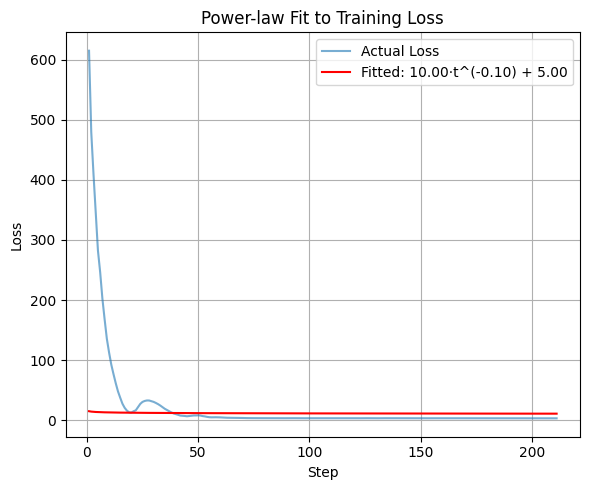

Fitted power-law parameters:
a = 10.0000, b = 0.0981, c = 5.0000


In [27]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Your actual loss values
# Assume: scores = np.array([...])  # shape (T,)
T = len(losses)
steps = np.arange(1, T + 1)

# Define power-law function
def power_law(t, a, b, c):
    return a * t**(-b) + c

# Fit the curve
popt, _ = curve_fit(power_law, steps, losses, bounds=([0, 0, 0], [10, 2, 5]))
a_fit, b_fit, c_fit = popt

# Generate fitted curve
fitted_loss = power_law(steps, *popt)

# Plot actual vs fitted
plt.figure(figsize=(6, 5))
plt.plot(steps, losses, label="Actual Loss", alpha=0.6)
plt.plot(steps, fitted_loss, label=f"Fitted: {a_fit:.2f}·t^(-{b_fit:.2f}) + {c_fit:.2f}", color='red')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Power-law Fit to Training Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: print constants
print(f"Fitted power-law parameters:\na = {a_fit:.4f}, b = {b_fit:.4f}, c = {c_fit:.4f}")

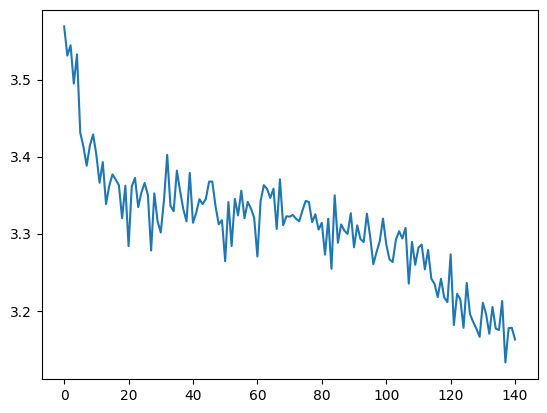

In [30]:
plt.plot(losses[70:])

In [293]:
torch.save(model.state_dict(), 'nan.pth')

In [6]:
import torch.profiler
device="cpu"
def profile_one_iter():
    model.train()
    xb, yb = next(iter(train_loader))
    xb, yb = xb.to(device), yb.to(device)

    with torch.profiler.profile(
        activities=[torch.profiler.ProfilerActivity.CPU],
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./logdir'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:

        optimizer.zero_grad()
        logits , attention= model(xb)
        B, T, V = logits.shape
        loss = criterion(logits.view(B*T, V), yb.view(B*T))
        loss.backward()
        optimizer.step()

    print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=20))
profile_one_iter()

[W511 16:15:53.846008000 CPUAllocator.cpp:245] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul        17.65%     857.732ms        17.68%     859.084ms     839.769us       8.93 Gb       8.93 Gb          1023  
                                              aten::exp        14.04%     682.467ms        14.04%     682.467ms       3.131ms       5.26 Gb       5.26 Gb           218  
                                              aten::sum        11.17%     542.596ms        17.74%     862.105ms       2.422ms     307.79 Mb     307.79

In [35]:
def fenchel_decode(logits, tau=1.0, iters=3):
    """Fenchel‑dual KL‑regularised projection of -logits (energy)."""
    energy = -logits                        # (B,V)
    p = torch.full_like(energy, 1.0 / energy.size(-1))  # uniform start
    for _ in range(iters):
        p = torch.softmax((-energy / tau) + p.log(), dim=-1)
    return p
    
# --- generation ------------------------------------------------------
use_fenchel   = False          # flip to compare
tau           = 1.0           # λ  (temperature analogue)
max_new_tokens = 1024
top_k          = 25
block_size     = 256
temperature    = 1.0

bcontext_str = "To be, or not to be,"
context_ids = torch.tensor([[ stoi[c] for c in bcontext_str ]],
                           dtype=torch.long)
context_ids = context_ids.to(device)


generated = context_ids.clone()  # (1,T0)
model.eval()
with torch.no_grad():
  for _ in range(max_new_tokens):
    input_ids = generated[:, -block_size:]        # casual block
    logits,a = model(input_ids)

    logits = logits[:, -1, :] / temperature
    # top‑k mask
    if top_k is not None:
        v, _ = torch.topk(logits, top_k)
        logits[logits < v[:, [-1]]] = -1e10

    if use_fenchel:
        probs = fenchel_decode(logits, tau=tau, iters=3)
    else:
        probs = torch.softmax(logits, dim=-1)

    next_id = torch.multinomial(probs, num_samples=1)   # (1,1)
    generated = torch.cat([generated, next_id], dim=1)

print('> ', ''.join(itos[i] for i in generated[0].tolist()))

>  To be, or not to be,ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc

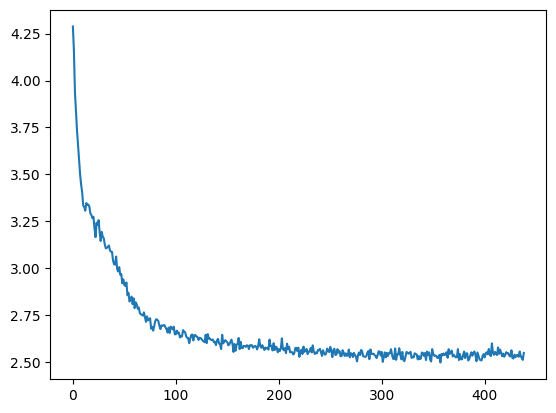

In [332]:
from matplotlib import pyplot as plt
plt.plot(losses)
